# Basin Hopping

#### Dylan Durkee - Spring 2019

Here, we are interested in minimizing the total energy for several different LJ clusters of atoms (from N=10 to N=20). Of course, the equation for the potential energy of an LJ cluster is given by the following equation:
$$ V = 4\epsilon \big[ \big(\frac{\delta}{r}\big)^{12} - \big(\frac{\delta}{r}\big)^{6} \big]$$

where we take the constants $\epsilon$ and $\delta$ to both be equal to 1.

I use the basin-hopping function from scipy to find the global minimum of three LJ configurations: N=13, 15, and 17. So how does the basin-hopping function work?

Basin hopping transforms the geometry of the potential energy surface (PES) into a series of staggered energy "basins." At each iteration of the algorithm, a random perturbation is performed on the coordinates, a local minimization is performed, and finally an acceptance test is evaluated on the new function value. The algorithm is summarized below.

### Basin-hopping algorithm

From scipy's source code file:

Basin-hopping is a stochastic algorithm which attempts to find the global
minimum of a smooth scalar function of one or more variables.
The algorithm is iterative with each cycle composed of the following
features.

1) random perturbation of the coordinates

2) local minimization

3) accept or reject the new coordinates based on the minimized function value

The acceptance test that the algorithm uses is based on the Metropolis criterion which uses Monte Carlo algorithms.


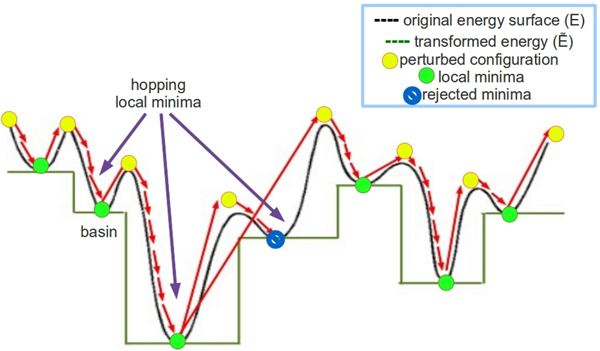

In [139]:
from IPython.display import Image
Image(filename='basin hopping3.jpg', width = 600, height=351)

### Parameters to Test:

From scipy's website, the basinhopping algorithm can take the following parameters:

**scipy.optimize.basinhopping(func, x0, niter=100, T=1.0, stepsize=0.5, minimizer_kwargs=None, take_step=None, accept_test=None, callback=None, interval=50, disp=False, niter_success=None, seed=None)**


The two most important parameters to evaluate in this function are temperature and stepsize. Below I summarize the importance in choosing approriate values for these parameters.

1) **Temperature (T)**: The parameter the basin hopping function uses in its acceptance evaluation. Basinhopping steps are always accepted if the new function value is lower in energy than the old. $$func(x_{new}) < func(x_{old})$$ 

Otherwise, they are accepted with probability: $$e^{-(func(x_{new})-func(x_{old}))/T}$$

For greater T values, greater changes in function values between local minima will be accepted. 
Note, however, that this is not the same as the "height" of the basin, or local minima. 


2) **Stepsize:** Choosing an approriate step size is equally important as temperature. 

For each iteration of the basin hopping function, the step size is chosen between $x_0-stepsize$ to $x_0+stepsize$ in each dimension. 

Scipy recommends choosing a step size that is comparable to the typical separation between local minima of the function being optimized.


Source for Basin-Hopping diagram above: Hashmi, Irina & Shehu, Amarda. (2013). HopDock: A probabilistic search algorithm for decoy sampling in protein-protein docking. Proteome science. 11. S6. 10.1186/1477-5956-11-S1-S6. 

In [6]:
import numpy as np
from numba import jit
from scipy.spatial.distance import cdist

In [7]:
@jit
def init_pos(N, L=5):
    """
    Intialize starting positions in x,y,z coordinates for N number of atoms.
    
    Return: Array with random Cartesian positions of N atoms.
    """
    return L*np.random.random_sample((N*3,))


@jit
def total_energy(positions):
    """
    Calculate the total energy
    
    input:
    positions: 1*N array which represents the atomic positions in Cartesian coordinates.
    
    output
    E: the total energy
    """
    E = 0
    #N_atom = int(len(positions))
    N_atom = int(len(positions)/3)
    
    #positions = [x0, y0, z0, x1, y1, z1, .....  , x(n-1), y(n-1), z(n-1)]
    for i in range(N_atom-1):
        for j in range(i+1, N_atom):
            pos1 = positions[i*3:(i+1)*3]
            pos2 = positions[j*3:(j+1)*3]
            dist = np.linalg.norm(pos1-pos2)
            r6 = dist**6
            r12 = r6*r6
            E += 4*(1/r12 - 1/r6)
    return E

In class, we ran many interations using a local minimization function from scipy until we were close enough to the true total energy of an LJ cluster. This was quite time-consuming, although using numba as well as the analytical gradient helped to speed up the computation. I now want to use scipy's basin-hopping global minimization method to compare its accuracy and time required for convergence. Furthermore, I would like to see how many iterations the basin-hopping technique will require for convergence. To save computing time, I import numba right away and include @jit before each function above.

The niter_success parameter allows one to stop the iterations if a specified amount of iterations have run with no new results (in this case, if no lower energy is computed). I will set this parameter to 10, and set n_iter to 20 for N=13, and 40 for the other two configurations.

First, I look at three LJ clusters with N_atoms = 13, 17, and 15. The true energies for these cluster sizes are:

- N=13: -44.326801
- N=17: -61.317995
- N=15: -52.322627

as reported by the Wales group. (http://doye.chem.ox.ac.uk/jon/structures/LJ/tables.150.html)

These will be our target energies.

In [143]:
from scipy.optimize import basinhopping
import time

In [148]:
"""
N = 13

Extreme 1: Large temperature value, small stepsize

"""

true_13 = -44.326801
N_13 = 13
pos_13 = init_pos(N_13)
start = time.time()
res_13 = basinhopping(func=total_energy, x0=pos_13, niter=20, T=15.0, stepsize=1.5, niter_success=10, disp=True)
print("Total time to convergence: ", time.time()-start, 's')
print("Global minimum value: ", res_13.fun)
print("True minimum value: ", true_13)

basinhopping step 0: f -39.5059
basinhopping step 1: f -34.131 trial_f -34.131 accepted 1  lowest_f -39.5059
basinhopping step 2: f -37.2574 trial_f -37.2574 accepted 1  lowest_f -39.5059
basinhopping step 3: f -37.7512 trial_f -37.7512 accepted 1  lowest_f -39.5059
basinhopping step 4: f -37.7512 trial_f -17.5054 accepted 0  lowest_f -39.5059
basinhopping step 5: f -38.4668 trial_f -38.4668 accepted 1  lowest_f -39.5059
basinhopping step 6: f -38.4668 trial_f -26.5792 accepted 0  lowest_f -39.5059
basinhopping step 7: f -35.3351 trial_f -35.3351 accepted 1  lowest_f -39.5059
basinhopping step 8: f -31.7752 trial_f -31.7752 accepted 1  lowest_f -39.5059
basinhopping step 9: f -31.7752 trial_f -3.00002 accepted 0  lowest_f -39.5059
basinhopping step 10: f -30.0416 trial_f -30.0416 accepted 1  lowest_f -39.5059
basinhopping step 11: f -33.0267 trial_f -33.0267 accepted 1  lowest_f -39.5059
Total time to convergence:  16.670809030532837 s
Global minimum value:  -39.50594379583438
True min

In [149]:
"""
N = 13

Extreme 2: Small temperature, large stepsize

"""

true_13 = -44.326801
N_13 = 13
pos_13 = init_pos(N_13)
start = time.time()
res_13 = basinhopping(func=total_energy, x0=pos_13, niter=40, T=1.5, stepsize=15.0,niter_success=10, disp=True)
print("Total time to convergence: ", time.time()-start, 's')
print("Global minimum value: ", res_13.fun)
print("True minimum value: ", true_13)

basinhopping step 0: f -37.4197
basinhopping step 1: f -37.4197 trial_f -18.5331 accepted 0  lowest_f -37.4197
basinhopping step 2: f -37.4197 trial_f -5.00002 accepted 0  lowest_f -37.4197
basinhopping step 3: f -37.4197 trial_f -1.00096 accepted 0  lowest_f -37.4197
basinhopping step 4: f -37.4197 trial_f -5.00004 accepted 0  lowest_f -37.4197
basinhopping step 5: f -37.4197 trial_f -6.00003 accepted 0  lowest_f -37.4197
basinhopping step 6: f -37.4197 trial_f -16.1039 accepted 0  lowest_f -37.4197
basinhopping step 7: f -37.4197 trial_f -3.21008 accepted 0  lowest_f -37.4197
basinhopping step 8: f -37.4197 trial_f -14 accepted 0  lowest_f -37.4197
basinhopping step 9: f -37.4197 trial_f -2.84813 accepted 0  lowest_f -37.4197
basinhopping step 10: f -37.4197 trial_f -3.00002 accepted 0  lowest_f -37.4197
basinhopping step 11: f -37.4197 trial_f -16.1039 accepted 0  lowest_f -37.4197
Total time to convergence:  14.77920913696289 s
Global minimum value:  -37.41970670510171
True minimum

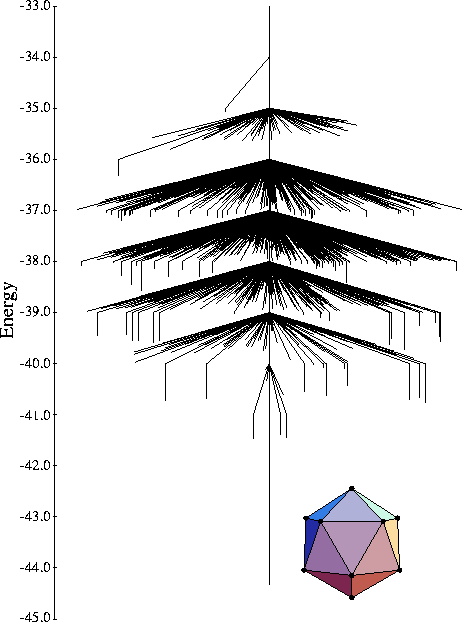

In [140]:
Image(filename='LJ13_tree.gif')

Luckily, we are working with systems whose minimum energy values are well known. Above is a forest diagram of the minima contained within the N=13 LJ cluster (obtained from the Cambridge group). As we can see, there are tens, perhaps hundres of minima within the PES. As we increase the number of atoms, the number of local minima within the PES exponentially increases. I want to try and adjust temperature and stepsize to appropriate values in order to hop between these minima to the global minimum basin.

In [7]:
"""

***BEST FOR N=13***

N = 13

Using T (temperature) parameter as well as adjusting stepsize

"""

true_13 = -44.326801
N_13 = 13
pos_13 = init_pos(N_13)
start = time.time()
res_13_1 = basinhopping(func=total_energy, x0=pos_13, niter=20, T=0.5, stepsize=2.0, niter_success=10, disp=True)
print("Total time to convergence: ", time.time()-start, 's')
print("Global minimum value: ", res_13_1.fun)
print("True minimum value: ", true_13)

basinhopping step 0: f -36.3021
basinhopping step 1: f -40.6155 trial_f -40.6155 accepted 1  lowest_f -40.6155
found new global minimum on step 1 with function value -40.6155
basinhopping step 2: f -39.6277 trial_f -39.6277 accepted 1  lowest_f -40.6155
basinhopping step 3: f -39.6277 trial_f -38.2332 accepted 0  lowest_f -40.6155
basinhopping step 4: f -39.6277 trial_f -33.0925 accepted 0  lowest_f -40.6155
basinhopping step 5: f -39.6277 trial_f -37.4197 accepted 0  lowest_f -40.6155
basinhopping step 6: f -44.3268 trial_f -44.3268 accepted 1  lowest_f -44.3268
found new global minimum on step 6 with function value -44.3268
basinhopping step 7: f -44.3268 trial_f -39.6825 accepted 0  lowest_f -44.3268
basinhopping step 8: f -44.3268 trial_f -34.3264 accepted 0  lowest_f -44.3268
basinhopping step 9: f -44.3268 trial_f -40.6155 accepted 0  lowest_f -44.3268
basinhopping step 10: f -44.3268 trial_f -39.6749 accepted 0  lowest_f -44.3268
basinhopping step 11: f -44.3268 trial_f -37.5806

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
18


<IPython.core.display.Javascript object>


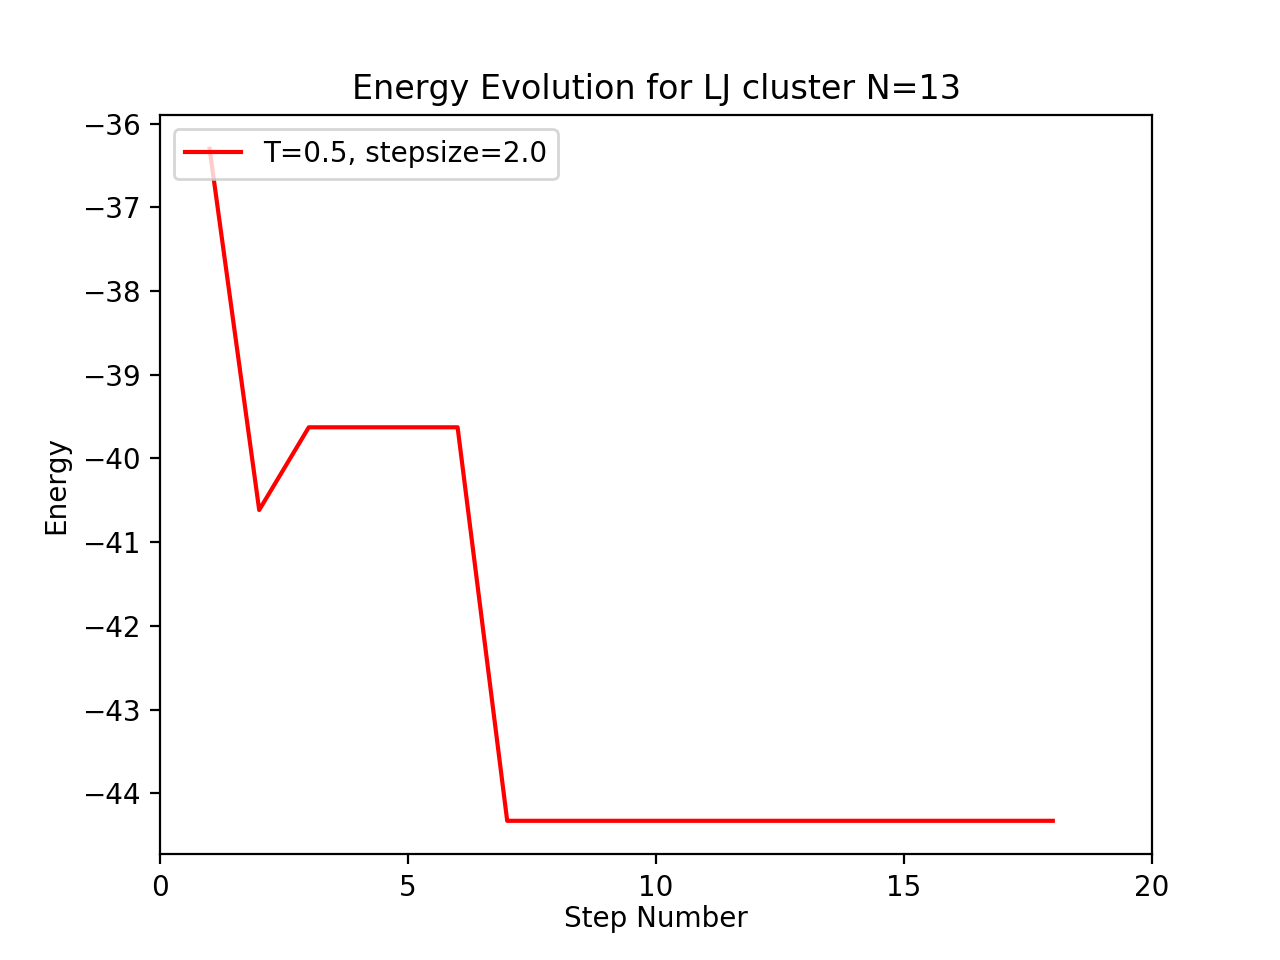

In [73]:
res_13_steps = list(range(1,19))
print(res_13_steps)
res_13_energies = [-36.3021,-40.6155,-39.6277,-39.6277,-39.6277,-39.6277,-44.3268,-44.3268,-44.3268,-44.3268,-44.3268,-44.3268,-44.3268,-44.3268,-44.3268,-44.3268,-44.3268,-44.3268]
print(len((res_13_energies)))

import matplotlib.pyplot as plt

plot_13 = plt.plot(res_13_steps, res_13_energies, 'r-', label='T=0.5, stepsize=2.0')
plt.xlabel("Step Number", labelpad=1)
plt.xticks([0, 5, 10, 15, 20])
plt.ylabel("Energy")
plt.title("Energy Evolution for LJ cluster N=13")
plt.legend(loc='upper left')
plt.savefig('N13_1.png')
plt.show()

In [22]:
print(res_13_1.x)
res13 = np.reshape(res_13_1.x, [int(res_13_1.x.shape[0]/3), 3])
print(res13)
print(res13[:,0])


[2.94393629 1.68858416 3.50711316 2.05600825 1.91091479 2.93046173
 2.07770934 2.81608543 2.3383728  2.57983992 2.75578435 3.3572754
 3.0039872  2.1709037  2.47866997 2.6668295  1.08931933 2.58081569
 1.16808032 2.13324545 2.35381002 1.53217656 1.06604531 2.50364798
 1.98054472 2.03567622 4.002429   1.10802915 1.65092607 3.38225332
 1.44518699 2.73251039 3.28010752 2.03430719 1.00574404 3.5225505
 2.13147168 1.78615341 1.85849433]
[[2.94393629 1.68858416 3.50711316]
 [2.05600825 1.91091479 2.93046173]
 [2.07770934 2.81608543 2.3383728 ]
 [2.57983992 2.75578435 3.3572754 ]
 [3.0039872  2.1709037  2.47866997]
 [2.6668295  1.08931933 2.58081569]
 [1.16808032 2.13324545 2.35381002]
 [1.53217656 1.06604531 2.50364798]
 [1.98054472 2.03567622 4.002429  ]
 [1.10802915 1.65092607 3.38225332]
 [1.44518699 2.73251039 3.28010752]
 [2.03430719 1.00574404 3.5225505 ]
 [2.13147168 1.78615341 1.85849433]]
[2.94393629 2.05600825 2.07770934 2.57983992 3.0039872  2.6668295
 1.16808032 1.53217656 1.98054

In [31]:
zmin, zmax = 1.85, 4.0
nz = np.linspace(zmin, zmax, 13)

<IPython.core.display.Javascript object>


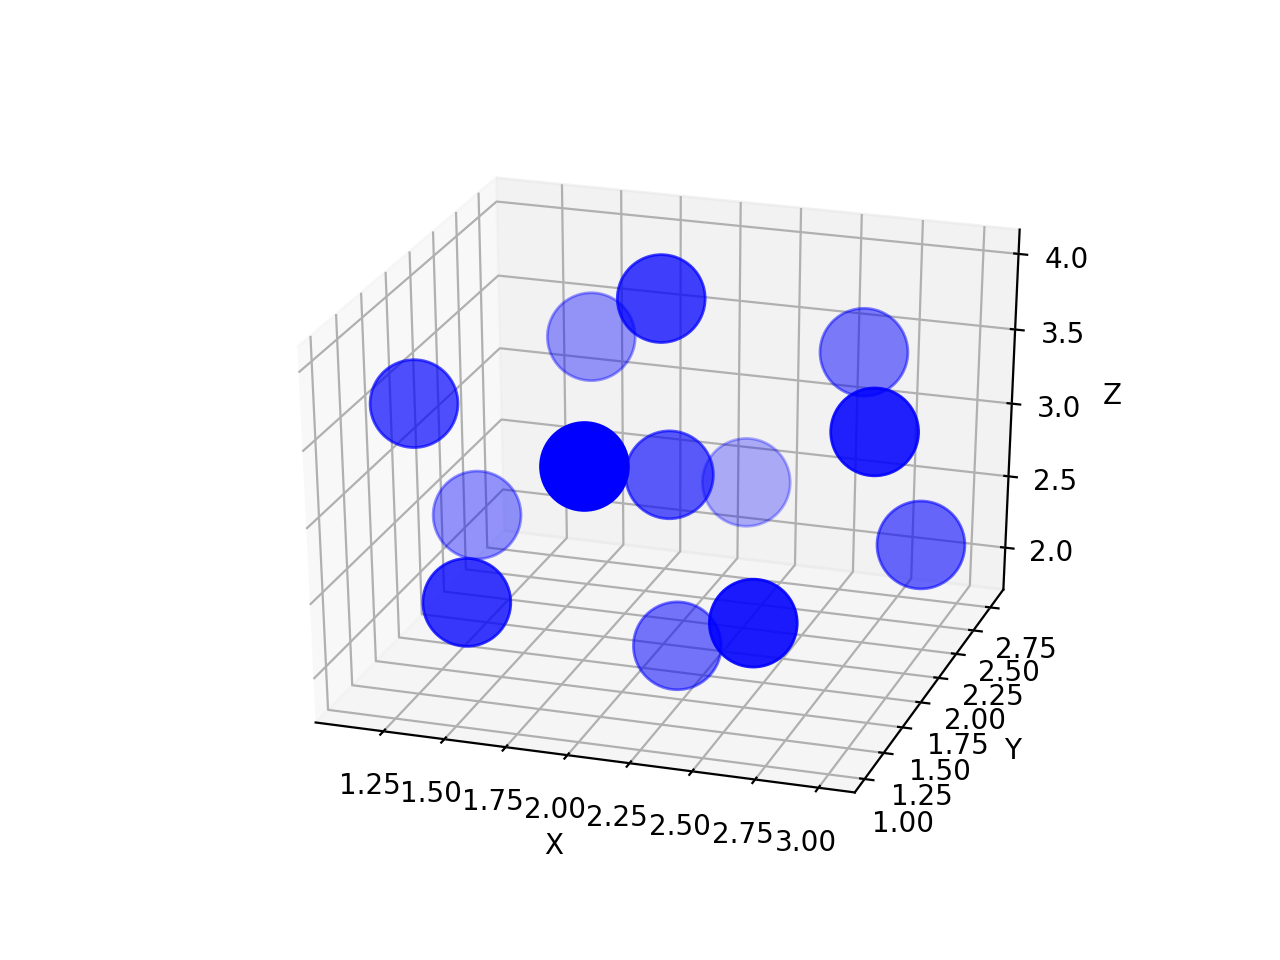

In [79]:

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

nx = np.linspace(1, 3.25, 10)
ny = np.linspace(0.75, 3, 10)
nz = [3, 3, 3, 3, 3, 3, 3, 3, 3, 3]

#x_mesh, y_mesh = np.meshgrid(nx, ny)
#print (y_mesh)

x, y, z = res13[:,0], res13[:,1], res13[:,2]
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(x, y, z, s=1000, c='blue', depthshade=True)
#cset = ax.contour(nz,ny,nz, zdir='nz', offset=0)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.savefig('N13_3D_2.png')
plt.show()


In [75]:
"""

***2nd BEST FOR N=13***

N = 13

Using T (temperature) parameter as well as adjusting stepsize

"""

true_13 = -44.326801
N_13 = 13
pos_13_2 = init_pos(N_13)
start = time.time()
res_13_2 = basinhopping(func=total_energy, x0=pos_13_2, niter=20, T=0.3, stepsize=3.0, niter_success=10, disp=True)
print("Total time to convergence: ", time.time()-start, 's')
print("Global minimum value: ", res_13_2.fun)
print("True minimum value: ", true_13)

basinhopping step 0: f -40.6046
basinhopping step 1: f -41.472 trial_f -41.472 accepted 1  lowest_f -41.472
found new global minimum on step 1 with function value -41.472
basinhopping step 2: f -41.472 trial_f -39.1576 accepted 0  lowest_f -41.472
basinhopping step 3: f -41.472 trial_f -37.5247 accepted 0  lowest_f -41.472
basinhopping step 4: f -41.472 trial_f -38.5476 accepted 0  lowest_f -41.472
basinhopping step 5: f -41.472 trial_f -37.7686 accepted 0  lowest_f -41.472
basinhopping step 6: f -41.472 trial_f -40.6155 accepted 0  lowest_f -41.472
basinhopping step 7: f -41.472 trial_f -40.5413 accepted 0  lowest_f -41.472
basinhopping step 8: f -41.3944 trial_f -41.3944 accepted 1  lowest_f -41.472
basinhopping step 9: f -41.3944 trial_f -35.3249 accepted 0  lowest_f -41.472
basinhopping step 10: f -44.3268 trial_f -44.3268 accepted 1  lowest_f -44.3268
found new global minimum on step 10 with function value -44.3268
basinhopping step 11: f -44.3268 trial_f -37.8725 accepted 0  lowe

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
21


<IPython.core.display.Javascript object>


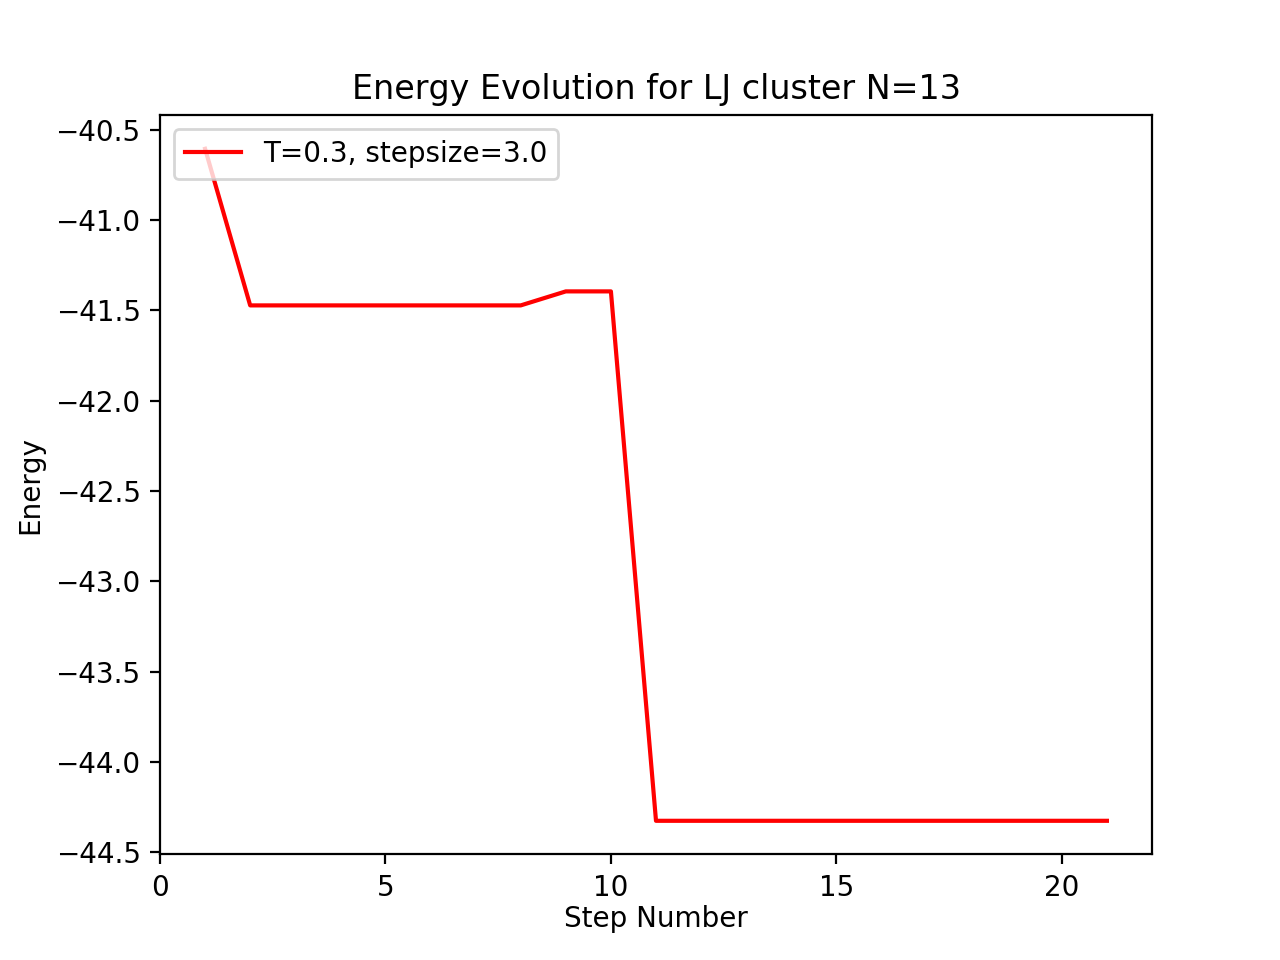

In [77]:
res_13_2_steps = list(range(1,22))
print(res_13_2_steps)
res_13_2_energies = [-40.6046,-41.472,-41.472,-41.472,-41.472,-41.472,-41.472,-41.472,-41.3944,-41.3944,-44.3268,-44.3268,-44.3268,-44.3268,-44.3268,-44.3268,-44.3268,-44.3268,-44.3268,-44.3268,-44.3268]
print(len((res_13_2_energies)))


plot_13_2 = plt.plot(res_13_2_steps, res_13_2_energies, 'r-', label='T=0.3, stepsize=3.0')
plt.xlabel("Step Number", labelpad=1)
plt.xticks([0, 5, 10, 15, 20])
plt.ylabel("Energy")
plt.title("Energy Evolution for LJ cluster N=13")
plt.legend(loc='upper left')
plt.savefig('N13_2.png')
plt.show()

In [27]:
"""
N = 17

**CLOSE**
"""

true_17 = -61.317995
N_17 = 17
pos_17 = init_pos(N_17)
start = time.time()
res_17 = basinhopping(func=total_energy, x0=pos_17, T=3.0, stepsize=4.0, niter=40, niter_success=10, disp=True)
print("Total time to convergence: ", time.time()-start, 's')
print("Global minimum value: ", res_17.fun)
print("True minimum value: ", true_17)

basinhopping step 0: f -58.2557
basinhopping step 1: f -55.2609 trial_f -55.2609 accepted 1  lowest_f -58.2557
basinhopping step 2: f -53.9896 trial_f -53.9896 accepted 1  lowest_f -58.2557
basinhopping step 3: f -58.5863 trial_f -58.5863 accepted 1  lowest_f -58.5863
found new global minimum on step 3 with function value -58.5863
basinhopping step 4: f -55.8605 trial_f -55.8605 accepted 1  lowest_f -58.5863
basinhopping step 5: f -54.2642 trial_f -54.2642 accepted 1  lowest_f -58.5863
basinhopping step 6: f -57.1036 trial_f -57.1036 accepted 1  lowest_f -58.5863
basinhopping step 7: f -57.3131 trial_f -57.3131 accepted 1  lowest_f -58.5863
basinhopping step 8: f -57.3131 trial_f -54.1847 accepted 0  lowest_f -58.5863
basinhopping step 9: f -57.3131 trial_f -55.264 accepted 0  lowest_f -58.5863
basinhopping step 10: f -53.1645 trial_f -53.1645 accepted 1  lowest_f -58.5863
basinhopping step 11: f -59.3362 trial_f -59.3362 accepted 1  lowest_f -59.3362
found new global minimum on step 1

In [28]:
"""
N = 17

**NOT CLOSE**
"""

true_17 = -61.317995
N_17 = 17
pos_17 = init_pos(N_17)
start = time.time()
res_17 = basinhopping(func=total_energy, x0=pos_17, T=0.5, stepsize=2.5, niter=40, niter_success=10, disp=True)
print("Total time to convergence: ", time.time()-start, 's')
print("Global minimum value: ", res_17.fun)
print("True minimum value: ", true_17)

basinhopping step 0: f -37.6196
basinhopping step 1: f -38.195 trial_f -38.195 accepted 1  lowest_f -38.195
found new global minimum on step 1 with function value -38.195
basinhopping step 2: f -38.195 trial_f -31.9147 accepted 0  lowest_f -38.195
basinhopping step 3: f -38.195 trial_f -37.6552 accepted 0  lowest_f -38.195
basinhopping step 4: f -42.6957 trial_f -42.6957 accepted 1  lowest_f -42.6957
found new global minimum on step 4 with function value -42.6957
basinhopping step 5: f -42.6957 trial_f -38.8228 accepted 0  lowest_f -42.6957
basinhopping step 6: f -42.6957 trial_f -39.4062 accepted 0  lowest_f -42.6957
basinhopping step 7: f -42.6957 trial_f -37.3121 accepted 0  lowest_f -42.6957
basinhopping step 8: f -42.6957 trial_f -36.243 accepted 0  lowest_f -42.6957
basinhopping step 9: f -42.6957 trial_f -26.4644 accepted 0  lowest_f -42.6957
basinhopping step 10: f -42.6957 trial_f -39.446 accepted 0  lowest_f -42.6957
basinhopping step 11: f -44.3268 trial_f -44.3268 accepted 

In [22]:
"""
N = 17

**BEST FOR N=17**
"""

true_17 = -61.317995
N_17 = 17
pos_17 = init_pos(N_17)
res_17_hist = []
start = time.time()
res_17 = basinhopping(func=total_energy, x0=pos_17, T=3.8, stepsize=5.5, niter=40, niter_success=10, disp=True)
print("Total time to convergence: ", time.time()-start, 's')
print("Global minimum value: ", res_17.fun)
print("True minimum value: ", true_17)

basinhopping step 0: f -59.3065
basinhopping step 1: f -59.3065 trial_f -54.5235 accepted 0  lowest_f -59.3065
basinhopping step 2: f -58.3324 trial_f -58.3324 accepted 1  lowest_f -59.3065
basinhopping step 3: f -57.2261 trial_f -57.2261 accepted 1  lowest_f -59.3065
basinhopping step 4: f -57.2261 trial_f -44.1384 accepted 0  lowest_f -59.3065
basinhopping step 5: f -58.1613 trial_f -58.1613 accepted 1  lowest_f -59.3065
basinhopping step 6: f -55.168 trial_f -55.168 accepted 1  lowest_f -59.3065
basinhopping step 7: f -61.318 trial_f -61.318 accepted 1  lowest_f -61.318
found new global minimum on step 7 with function value -61.318
basinhopping step 8: f -61.318 trial_f -57.3301 accepted 0  lowest_f -61.318
basinhopping step 9: f -61.318 trial_f -58.8486 accepted 0  lowest_f -61.318
basinhopping step 10: f -58.3738 trial_f -58.3738 accepted 1  lowest_f -61.318
basinhopping step 11: f -58.3738 trial_f -53.2566 accepted 0  lowest_f -61.318
basinhopping step 12: f -58.02 trial_f -58.02

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
19


<IPython.core.display.Javascript object>


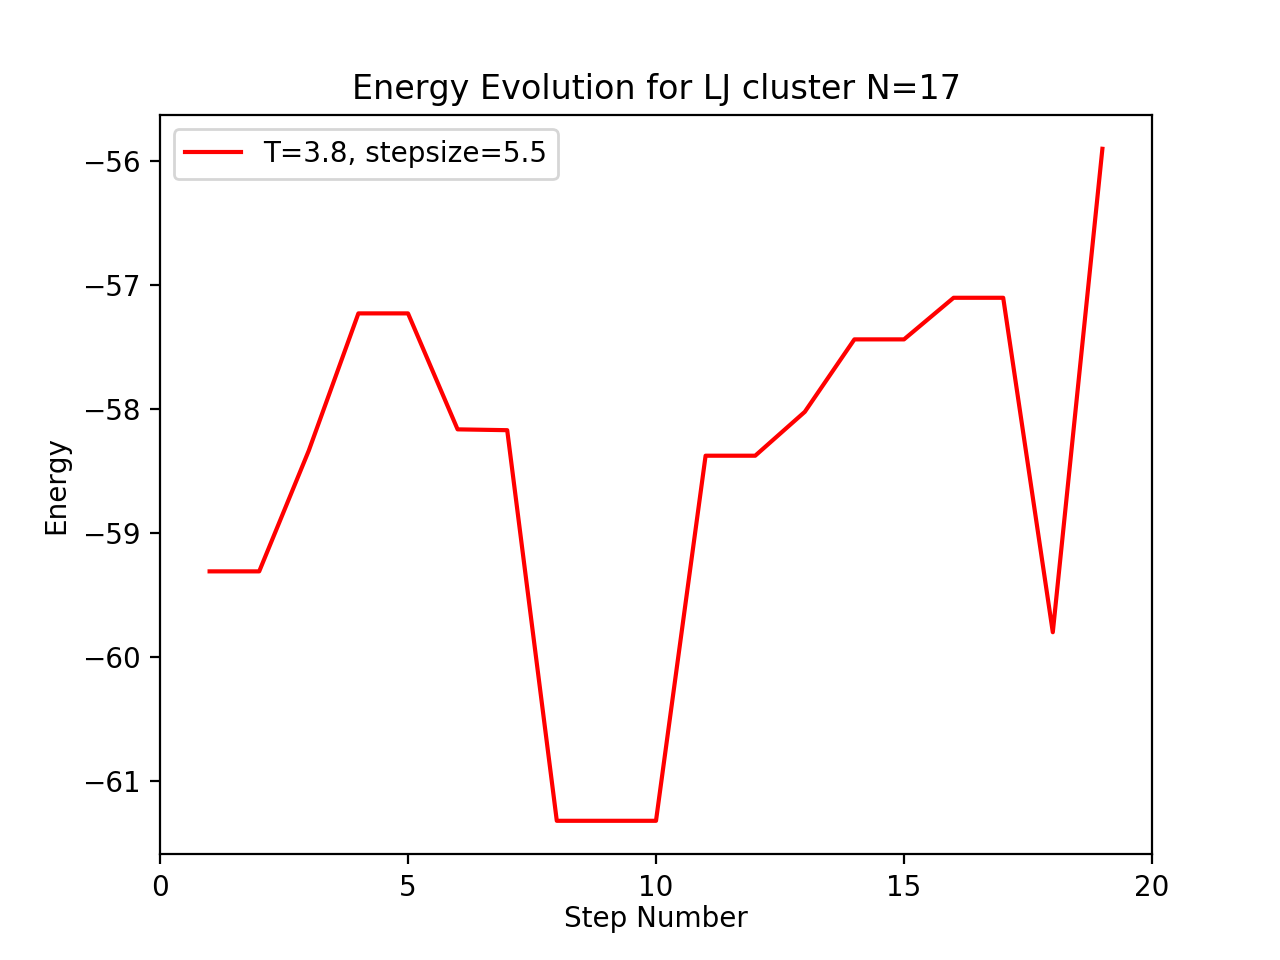

In [80]:
res_17_steps = list(range(1,20))
print(res_17_steps)
res_17_energies = [-59.3065, -59.3065, -58.3324, -57.2261, -57.2261, -58.1613, -58.168, -61.318,-61.318,-61.318, -58.3738, -58.3738, -58.02, -57.4357, -57.4357, -57.1002, -57.1002, -59.7972, -55.8988]
print(len((res_17_energies)))

import matplotlib.pyplot as plt

plt.plot(res_17_steps, res_17_energies, 'r-', label='T=3.8, stepsize=5.5')
plt.xlabel("Step Number", labelpad=1)
plt.xticks([0, 5, 10, 15, 20])
plt.ylabel("Energy")
plt.title("Energy Evolution for LJ cluster N=17")
plt.legend(loc='upper left')
plt.savefig('N17_Energy.png')
plt.show()

In [102]:
"""
N = 17

**VISUALIZATION FOR N=17**
"""

true_17 = -61.317995
N_17 = 17
pos_17 = init_pos(N_17)
start = time.time()
res_17_3 = basinhopping(func=total_energy, x0=pos_17, T=3.8, stepsize=5.2, niter=40, niter_success=10, disp=True)
print("Total time to convergence: ", time.time()-start, 's')
print("Global minimum value: ", res_17_3.fun)
print("True minimum value: ", true_17)

basinhopping step 0: f -56.7567
basinhopping step 1: f -61.2968 trial_f -61.2968 accepted 1  lowest_f -61.2968
found new global minimum on step 1 with function value -61.2968
basinhopping step 2: f -61.2968 trial_f -54.1073 accepted 0  lowest_f -61.2968
basinhopping step 3: f -61.2968 trial_f -59.1322 accepted 0  lowest_f -61.2968
basinhopping step 4: f -61.2968 trial_f -58.02 accepted 0  lowest_f -61.2968
basinhopping step 5: f -61.2968 trial_f -52.2186 accepted 0  lowest_f -61.2968
basinhopping step 6: f -59.4868 trial_f -59.4868 accepted 1  lowest_f -61.2968
basinhopping step 7: f -55.4617 trial_f -55.4617 accepted 1  lowest_f -61.2968
basinhopping step 8: f -59.3362 trial_f -59.3362 accepted 1  lowest_f -61.2968
basinhopping step 9: f -59.3362 trial_f -55.1119 accepted 0  lowest_f -61.2968
basinhopping step 10: f -59.3362 trial_f -53.003 accepted 0  lowest_f -61.2968
basinhopping step 11: f -58.214 trial_f -58.214 accepted 1  lowest_f -61.2968
basinhopping step 12: f -54.9243 trial

In [109]:
res17 = np.reshape(res_17_3.x, [int(res_17_3.x.shape[0]/3), 3])

<IPython.core.display.Javascript object>


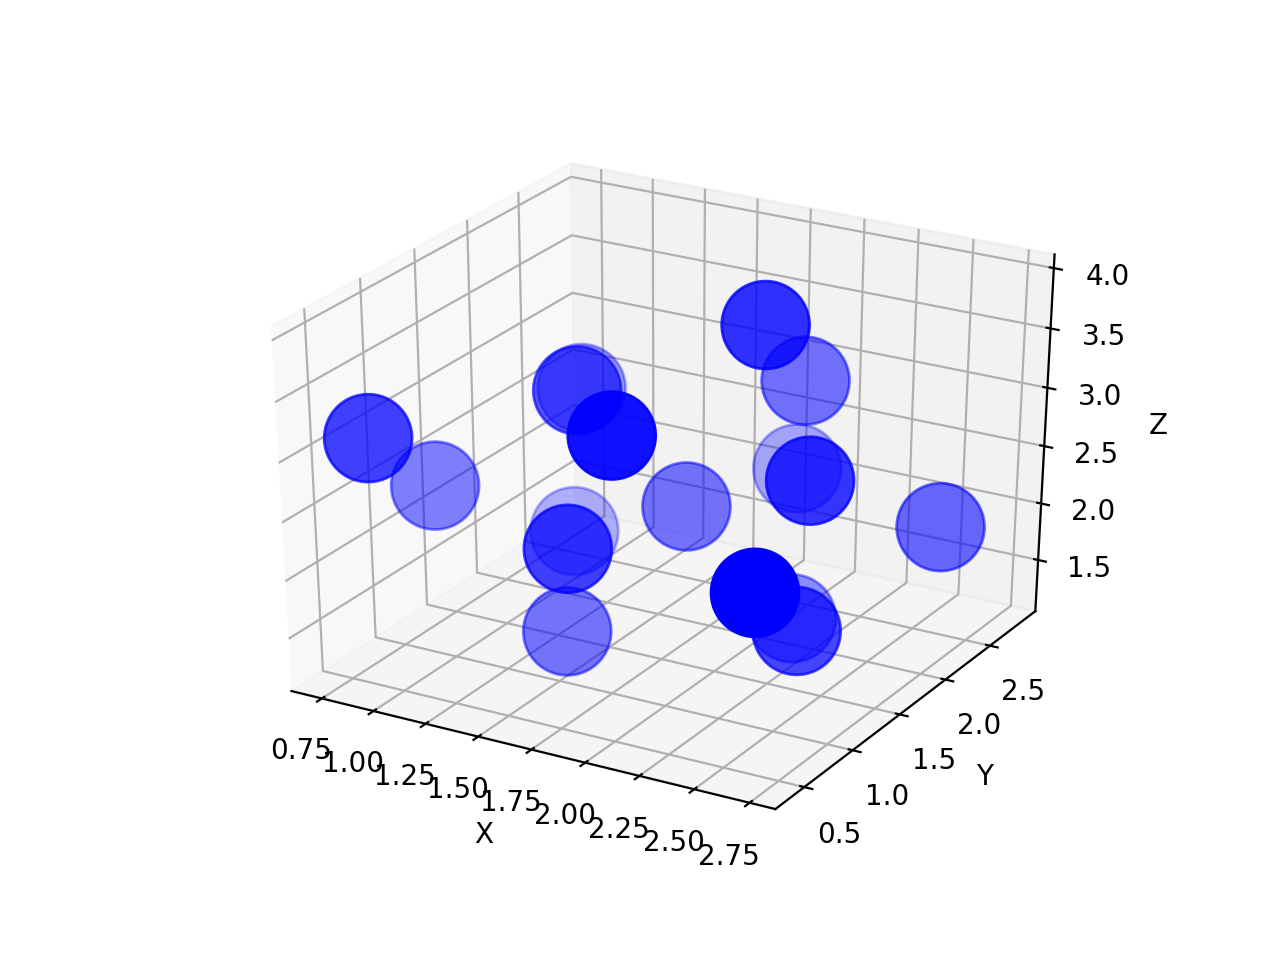

In [113]:
#import matplotlib.pyplot as plt
#from mpl_toolkits.mplot3d import Axes3D

#nx = np.linspace(1, 3.25, 10)
#ny = np.linspace(0.75, 3, 10)
#nz = [3, 3, 3, 3, 3, 3, 3, 3, 3, 3]

#x_mesh, y_mesh = np.meshgrid(nx, ny)
#print (y_mesh)

x17, y17, z17 = res17[:,0], res17[:,1], res17[:,2]
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(x17, y17, z17, s=1000, c='blue', depthshade=True)
#cset = ax.contour(nz,ny,nz, zdir='nz', offset=0)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.savefig('N17_3D_1.png')
plt.show()

In [77]:
"""
N = 17

**2nd BEST FOR N=17**
"""

true_17 = -61.317995
N_17 = 17
pos_17_2 = init_pos(N_17)
start = time.time()
res_17_2 = basinhopping(func=total_energy, x0=pos_17_2, T=4.2, stepsize=4.9, niter=40, niter_success=10, disp=True)
print("Total time to convergence: ", time.time()-start, 's')
print("Global minimum value: ", res_17_2.fun)
print("True minimum value: ", true_17)

basinhopping step 0: f -55.8324
basinhopping step 1: f -56.678 trial_f -56.678 accepted 1  lowest_f -56.678
found new global minimum on step 1 with function value -56.678
basinhopping step 2: f -56.678 trial_f -45.3456 accepted 0  lowest_f -56.678
basinhopping step 3: f -59.8265 trial_f -59.8265 accepted 1  lowest_f -59.8265
found new global minimum on step 3 with function value -59.8265
basinhopping step 4: f -59.4293 trial_f -59.4293 accepted 1  lowest_f -59.8265
basinhopping step 5: f -59.4293 trial_f -58.8146 accepted 0  lowest_f -59.8265
basinhopping step 6: f -59.4293 trial_f -56.1323 accepted 0  lowest_f -59.8265
basinhopping step 7: f -59.4293 trial_f -52.9933 accepted 0  lowest_f -59.8265
basinhopping step 8: f -61.0945 trial_f -61.0945 accepted 1  lowest_f -61.0945
found new global minimum on step 8 with function value -61.0945
basinhopping step 9: f -61.0945 trial_f -57.9398 accepted 0  lowest_f -61.0945
basinhopping step 10: f -61.0945 trial_f -54.2176 accepted 0  lowest_f 

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
30


<IPython.core.display.Javascript object>


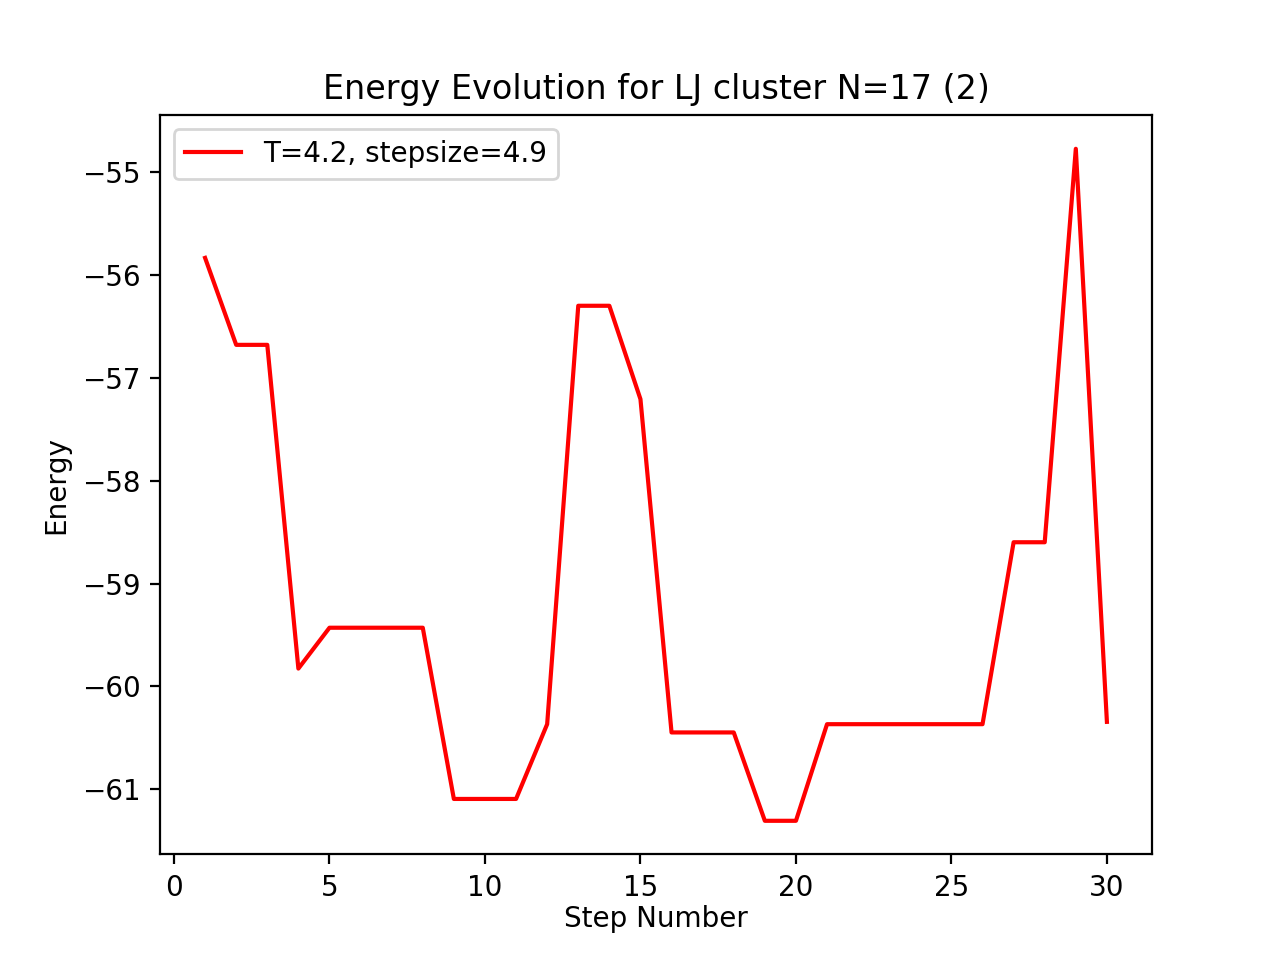

In [81]:
res_17_2_steps = list(range(1,31))
print(res_17_2_steps)
res_17_2_energies = [-55.832, -56.678, -56.678, -59.8265, -59.4293, -59.4293, -59.4293, -59.4293, -61.0945, -61.0945, -61.0945, -60.3674, -56.2979, -56.2979, -57.2061, -60.4477,-60.4477,-60.4477, -61.3071, -61.3071, -60.3674,-60.3674,-60.3674,-60.3674,-60.3674,-60.3674, -58.5979, -58.5979, -54.7712, -60.3448]
print(len((res_17_2_energies)))

import matplotlib.pyplot as plt

plt.plot(res_17_2_steps, res_17_2_energies, 'r-', label='T=4.2, stepsize=4.9')
plt.xlabel("Step Number", labelpad=1)
plt.xticks([0, 5, 10, 15, 20, 25, 30])
plt.ylabel("Energy")
plt.title("Energy Evolution for LJ cluster N=17 (2)")
plt.legend(loc='upper left')
plt.savefig('N17_Energy_2.png')
plt.show()

In [29]:
"""
N = 15

**BEST FOR N=15**
"""

true_15 = -52.322627
N_15 = 15
pos_15 = init_pos(N_15)
start = time.time()
res_15 = basinhopping(func=total_energy, x0=pos_15, niter=40, T=3.2, stepsize=4.4, niter_success=10, disp=True)
print("Total time to convergence: ", time.time()-start, 's')
print("Global minimum value: ", res_15.fun)
print("True minimum value: ", true_15)

basinhopping step 0: f -44.0357
basinhopping step 1: f -47.5827 trial_f -47.5827 accepted 1  lowest_f -47.5827
found new global minimum on step 1 with function value -47.5827
basinhopping step 2: f -51.3659 trial_f -51.3659 accepted 1  lowest_f -51.3659
found new global minimum on step 2 with function value -51.3659
basinhopping step 3: f -51.3659 trial_f -45.3307 accepted 0  lowest_f -51.3659
basinhopping step 4: f -51.3659 trial_f -42.0481 accepted 0  lowest_f -51.3659
basinhopping step 5: f -49.4419 trial_f -49.4419 accepted 1  lowest_f -51.3659
basinhopping step 6: f -52.3226 trial_f -52.3226 accepted 1  lowest_f -52.3226
found new global minimum on step 6 with function value -52.3226
basinhopping step 7: f -49.3263 trial_f -49.3263 accepted 1  lowest_f -52.3226
basinhopping step 8: f -48.5862 trial_f -48.5862 accepted 1  lowest_f -52.3226
basinhopping step 9: f -52.3226 trial_f -52.3226 accepted 1  lowest_f -52.3226
found new global minimum on step 9 with function value -52.3226
b

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
21


<IPython.core.display.Javascript object>


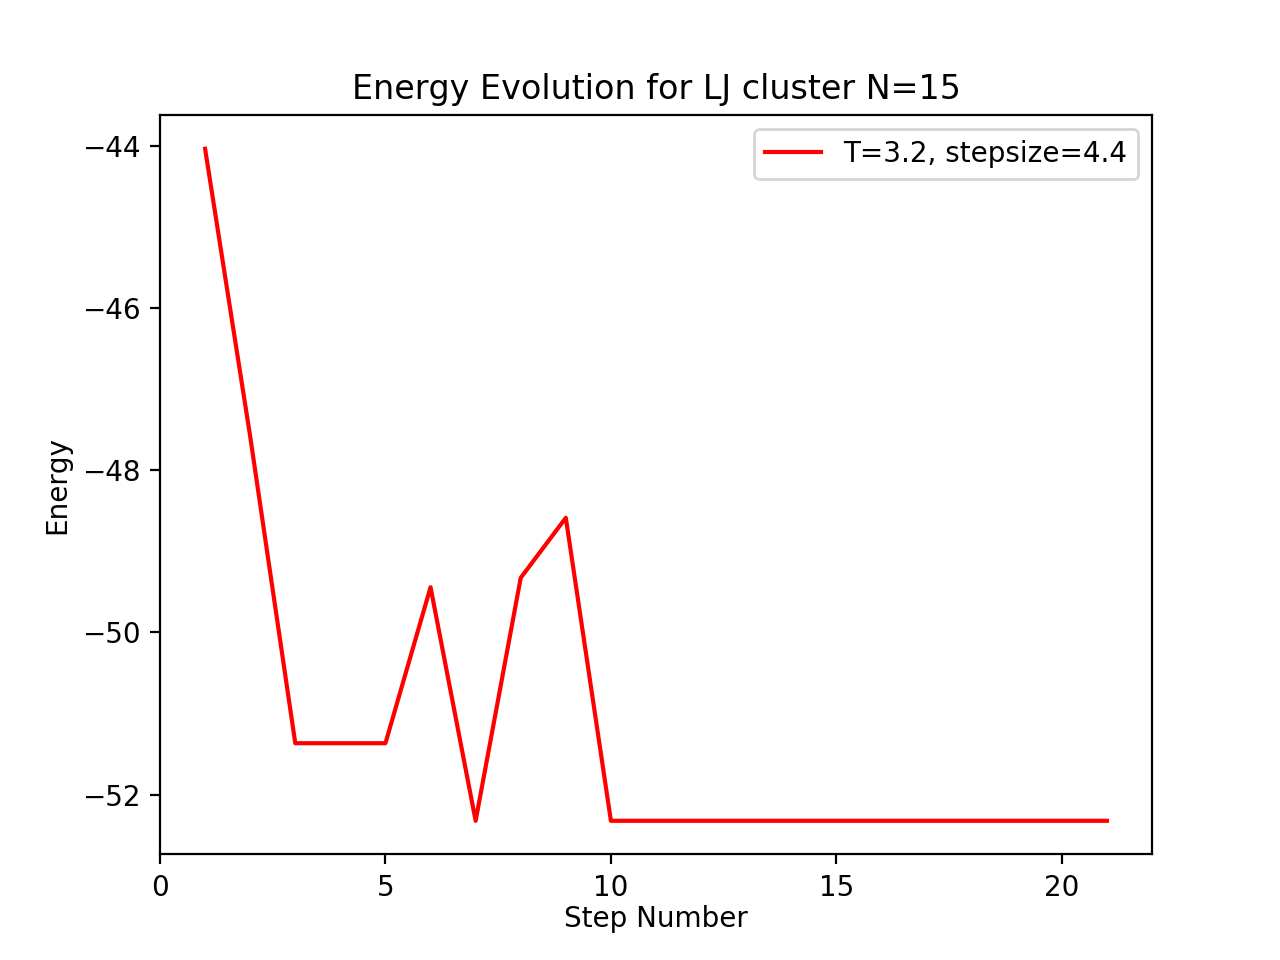

In [82]:
res_15_steps = list(range(1,22))
print(res_15_steps)
res_15_energies = [-44.0357, -47.5827, -51.3659,-51.3659,-51.3659, -49.4419, -52.3226, -49.3263, -48.5862, -52.3226, -52.3226, -52.3226, -52.3226, -52.3226, -52.3226, -52.3226, -52.3226, -52.3226, -52.3226, -52.3226, -52.3226]
print(len((res_15_energies)))

import matplotlib.pyplot as plt

plt.plot(res_15_steps, res_15_energies, 'r-', label='T=3.2, stepsize=4.4')
plt.xlabel("Step Number", labelpad=1)
plt.xticks([0, 5, 10, 15, 20])
plt.ylabel("Energy")
plt.title("Energy Evolution for LJ cluster N=15")
plt.legend(loc='upper right')
plt.savefig('N15_Energy.png')
plt.show()

In [31]:
"""
N = 15

**2nd best for N15**
"""

true_15 = -52.322627
N_15 = 15
pos_15 = init_pos(N_15)
start = time.time()
res_15 = basinhopping(func=total_energy, x0=pos_15, niter=40, T=3.4, stepsize=4.4, niter_success=10, disp=True)
print("Total time to convergence: ", time.time()-start, 's')
print("Global minimum value: ", res_15.fun)
print("True minimum value: ", true_15)

basinhopping step 0: f -48.382
basinhopping step 1: f -48.382 trial_f -44.2084 accepted 0  lowest_f -48.382
basinhopping step 2: f -47.7233 trial_f -47.7233 accepted 1  lowest_f -48.382
basinhopping step 3: f -47.0594 trial_f -47.0594 accepted 1  lowest_f -48.382
basinhopping step 4: f -49.6667 trial_f -49.6667 accepted 1  lowest_f -49.6667
found new global minimum on step 4 with function value -49.6667
basinhopping step 5: f -49.6667 trial_f -46.559 accepted 0  lowest_f -49.6667
basinhopping step 6: f -48.382 trial_f -48.382 accepted 1  lowest_f -49.6667
basinhopping step 7: f -45.6825 trial_f -45.6825 accepted 1  lowest_f -49.6667
basinhopping step 8: f -45.2704 trial_f -45.2704 accepted 1  lowest_f -49.6667
basinhopping step 9: f -47.0969 trial_f -47.0969 accepted 1  lowest_f -49.6667
basinhopping step 10: f -48.4025 trial_f -48.4025 accepted 1  lowest_f -49.6667
basinhopping step 11: f -44.3363 trial_f -44.3363 accepted 1  lowest_f -49.6667
basinhopping step 12: f -48.4186 trial_f 

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
27


<IPython.core.display.Javascript object>


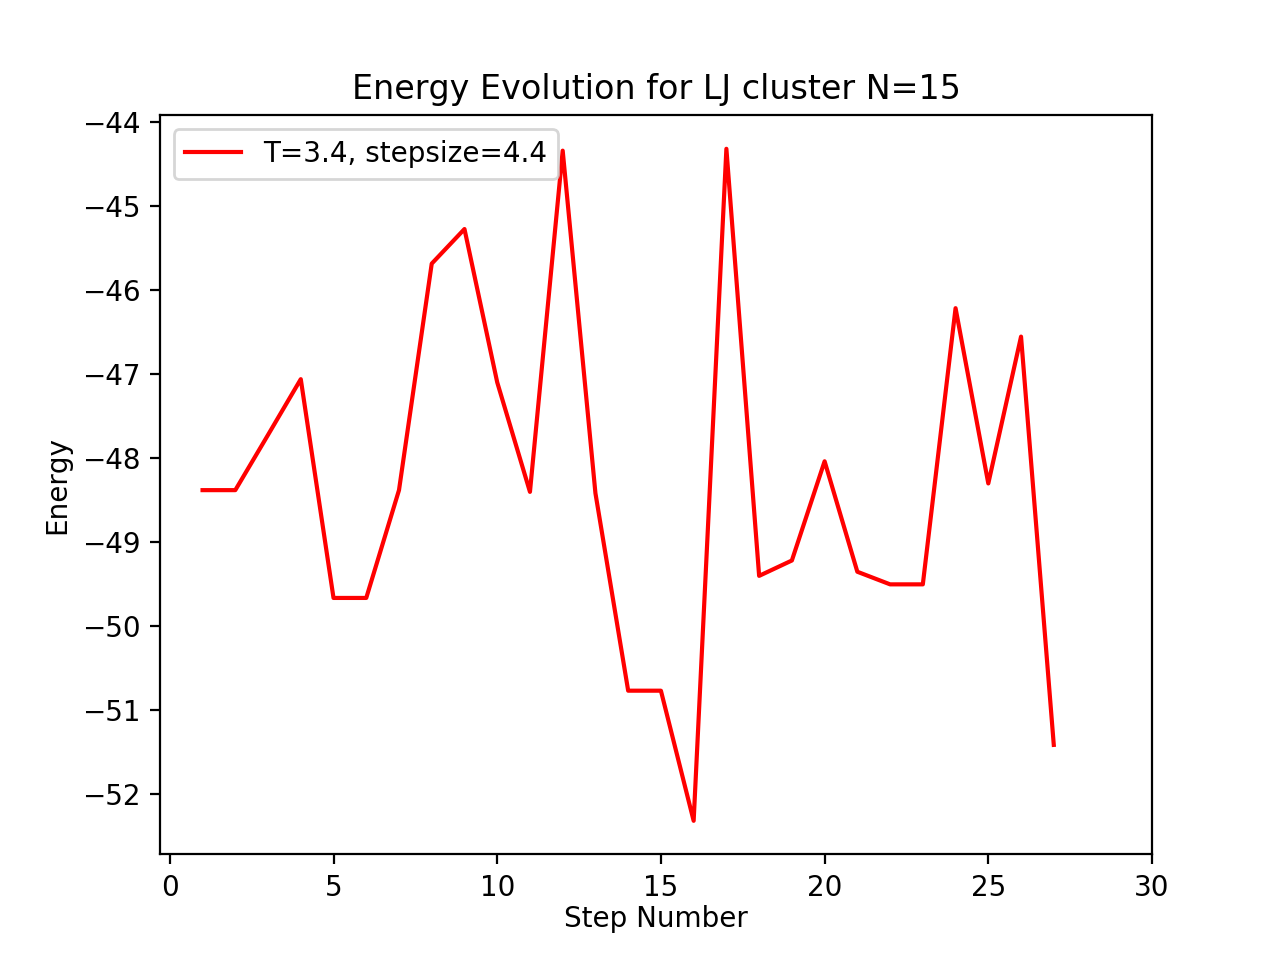

In [83]:
res_15_2_steps = list(range(1,28))
print(res_15_2_steps)
res_15_2_energies = [-48.382, -48.382, -47.7233, -47.0594, -49.6667, -49.6667, -48.382, -45.6825, -45.2704, -47.0969, -48.4025, -44.3363, -48.4186,-50.772,-50.772,-52.3226,-44.3141,-49.4037,-49.2204,-48.0381,-49.3546,-49.5048,-49.5048,-46.2135,-48.302,-46.5524,-51.418]
print(len((res_15_2_energies)))

import matplotlib.pyplot as plt

plt.plot(res_15_2_steps, res_15_2_energies, 'r-', label='T=3.4, stepsize=4.4')
plt.xlabel("Step Number", labelpad=1)
plt.xticks([0, 5, 10, 15, 20, 25, 30])
plt.ylabel("Energy")
plt.title("Energy Evolution for LJ cluster N=15")
plt.legend(loc='upper left')
plt.savefig('N15_Energy_2.png')
plt.show()

In [117]:
"""
N = 15

VISUALISATION
"""

true_15 = -52.322627
N_15 = 15
pos_15 = init_pos(N_15)
start = time.time()
res_15_3 = basinhopping(func=total_energy, x0=pos_15, niter=40, T=3.2, stepsize=4.4, niter_success=10, disp=True)
print("Total time to convergence: ", time.time()-start, 's')
print("Global minimum value: ", res_15_3.fun)
print("True minimum value: ", true_15)

basinhopping step 0: f -46.5411
basinhopping step 1: f -45.0502 trial_f -45.0502 accepted 1  lowest_f -46.5411
basinhopping step 2: f -49.4015 trial_f -49.4015 accepted 1  lowest_f -49.4015
found new global minimum on step 2 with function value -49.4015
basinhopping step 3: f -52.3226 trial_f -52.3226 accepted 1  lowest_f -52.3226
found new global minimum on step 3 with function value -52.3226
basinhopping step 4: f -52.3226 trial_f -44.1545 accepted 0  lowest_f -52.3226
basinhopping step 5: f -52.3226 trial_f -45.8933 accepted 0  lowest_f -52.3226
basinhopping step 6: f -52.3226 trial_f -50.2677 accepted 0  lowest_f -52.3226
basinhopping step 7: f -52.3226 trial_f -47.4751 accepted 0  lowest_f -52.3226
basinhopping step 8: f -47.4917 trial_f -47.4917 accepted 1  lowest_f -52.3226
basinhopping step 9: f -47.4917 trial_f -45.3406 accepted 0  lowest_f -52.3226
basinhopping step 10: f -52.3226 trial_f -52.3226 accepted 1  lowest_f -52.3226
found new global minimum on step 10 with function

In [120]:
res15 = np.reshape(res_15_3.x, [int(res_15_3.x.shape[0]/3), 3])

<IPython.core.display.Javascript object>


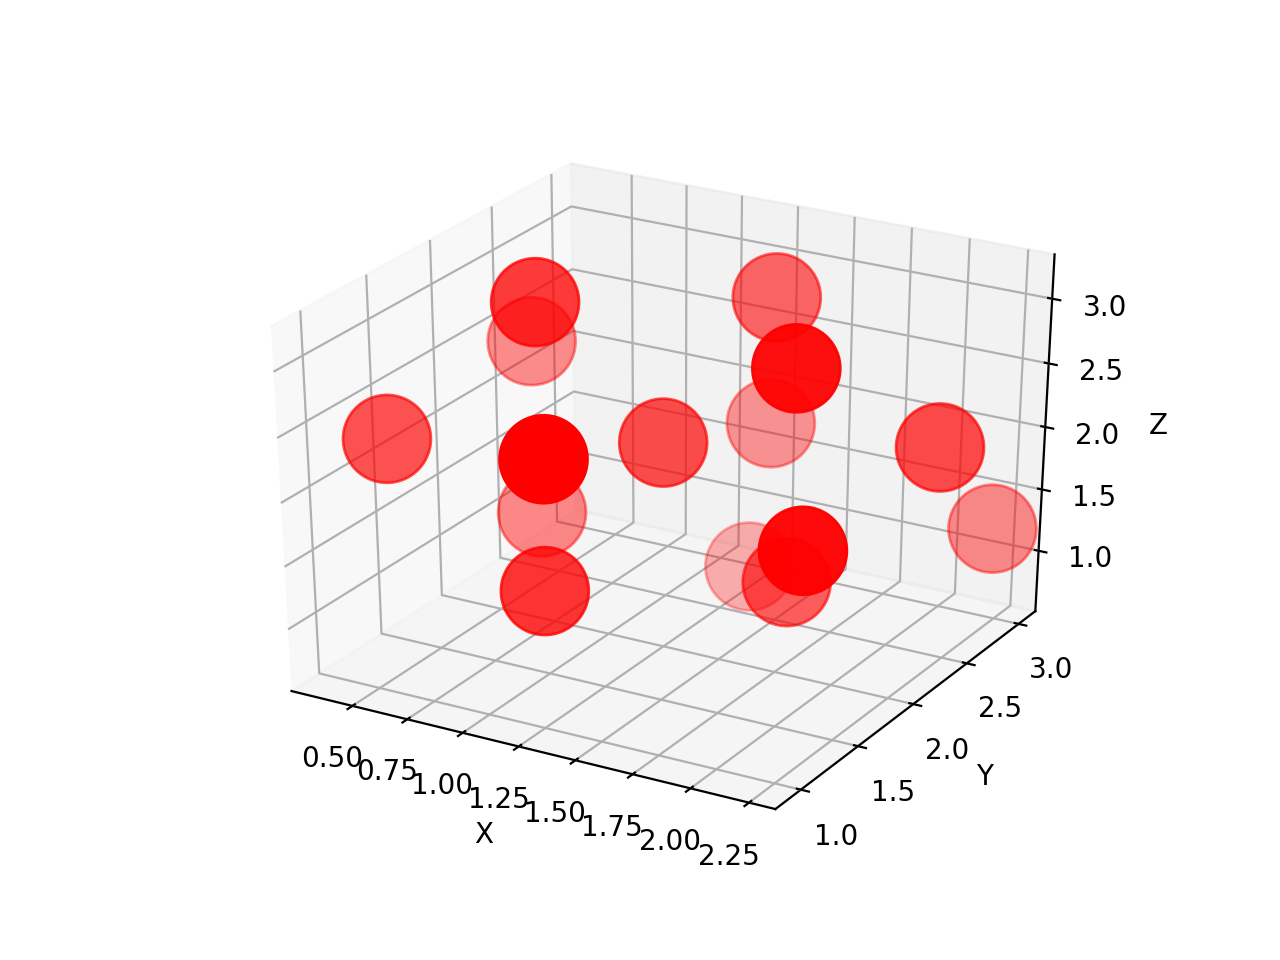

In [123]:
x15, y15, z15 = res15[:,0], res15[:,1], res15[:,2]
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(x15, y15, z15, s=1000, c='red', depthshade=True)
#cset = ax.contour(nz,ny,nz, zdir='nz', offset=0)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.savefig('N15_3D_1.png')
plt.show()

In [5]:
"""

Temperature Parameter vs. Number of Atoms


"""
import pandas as pd

N_atoms = [13, 15, 17]
Temp_1 = [0.5, 3.4, 3.8]
stepsize_1 = [2.0, 4.4, 5.5]
Temp_2 = [0.3, 3.2, 3.8]
stepsize_2 = [3.0, 4.4, 4.9 ]

"""
plt.scatter(N_atoms, Temp_1)
plt.scatter(N_atoms, Temp_2)
plt.xlabel("Number of atoms")
plt.ylabel("T parameter")
plt.title("T parameter Comparison")
plt.savefig('Tparam_comparison.png')
plt.show()
"""

table_1 = pd.DataFrame({
    'Number of atoms': N_atoms,
    'Temperature value': Temp_1,
    'Stepsize value': stepsize_1
    })

table_2 = pd.DataFrame({
    'Number of atoms': N_atoms,
    'Temperature value': Temp_2,
    'Stepsize value': stepsize_2
    })

table_1

,Number of atoms,Temperature value,Stepsize value
0,13,0.5,2.0
1,15,3.4,4.4
2,17,3.8,5.5


In [4]:
table_2

,Number of atoms,Temperature value,Stepsize value
0,13,0.3,3.0
1,15,3.2,4.4
2,17,3.8,4.9
